In [1]:
import pandas as pd
pd.set_option('display.max_rows', 1000)  # or 1000
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import seaborn as sns

from scipy.signal import savgol_filter
import pingouin as pg
from sklearn.linear_model import SGDClassifier
import dabest

import warnings
warnings.filterwarnings('ignore')

/Users/Oliver/miniconda3/envs/hippnac/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/Oliver/miniconda3/envs/hippnac/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
comps = pd.read_feather('/Users/Oliver/Google Drive/hippnac/data/final_submission/comps.feather')
C = pd.read_hdf('/Users/Oliver/Google Drive/hippnac/data/final_submission/C.h5', 'C')
S = pd.read_hdf('/Users/Oliver/Google Drive/hippnac/data/final_submission/S.h5', 'S')
behaviour = pd.read_hdf('/Users/Oliver/Google Drive/hippnac/data/final_submission/behaviour.h5', 'behaviour')
success_comreward = pd.read_feather('/Users/Oliver/Google Drive/hippnac/data/final_submission/success_comreward.feather')

comps

,ExpID,NeuronID,COM_x,COM_y,Red,VeloCorrelation,VeloCorrelationP,LickingIdx,PlaceScore,PlaceScoreShufflingPercentile,...,C_onset_lickbout_initial_shuffle_neg90,C_onset_lickbout_initial_shuffle_neg91,C_onset_lickbout_initial_shuffle_neg92,C_onset_lickbout_initial_shuffle_neg93,C_onset_lickbout_initial_shuffle_neg94,C_onset_lickbout_initial_shuffle_neg95,C_onset_lickbout_initial_shuffle_neg96,C_onset_lickbout_initial_shuffle_neg97,C_onset_lickbout_initial_shuffle_neg98,C_onset_lickbout_initial_shuffle_neg99
0,100,0,231.327754,163.246358,False,-0.011470,0.953807,0.192816,0.715640,44.4,...,False,False,False,True,False,False,False,False,False,True
1,100,1,85.803925,297.011614,False,-0.226335,0.246801,NaN,6.173925,82.3,...,False,False,False,False,False,False,False,False,False,False
2,100,2,81.299596,230.208318,False,-0.095840,0.627579,NaN,5.433429,77.6,...,False,False,False,False,False,False,False,False,False,False
3,100,3,49.978551,361.024682,False,0.215721,0.270248,NaN,4.326201,71.7,...,False,False,False,False,False,False,False,False,False,False
4,100,4,365.519515,321.801320,False,-0.388128,0.041257,0.080195,8.821839,94.9,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5367,166,918,485.109722,287.417032,False,-0.384738,0.043218,NaN,4.517022,99.5,...,False,False,False,False,False,False,False,False,False,False
5368,166,919,391.570251,438.940664,False,0.031838,0.872229,NaN,1.759884,97.0,...,False,True,False,False,True,False,False,False,False,False
5369,166,920,734.789844,721.921729,False,-0.427842,0.023137,NaN,5.616556,78.6,...,False,False,False,False,False,False,False,False,False,False
5370,166,921,491.045679,562.901971,False,-0.472598,0.011099,NaN,5.598232,78.6,...,False,False,False,False,False,False,False,False,False,False


In [3]:
# DEFINE SUCCESSFUL LAPS FOR REWARD ZONE AT END
if 'ExpID' in comps.columns:
    comps = comps.set_index(['ExpID', 'NeuronID'])
behaviour_end = behaviour

LickSum = behaviour_end.groupby(['ExpID', 'Mouse', 'Lap']).sum()['Licking']
PumpMaxpLap = behaviour_end.groupby(['ExpID', 'Mouse', 'Lap']).max()['Pump']
LickRatio = behaviour_end.loc[behaviour_end.Position>300].groupby(['ExpID', 'Mouse', 'Lap']).sum()['Licking'] / LickSum
TimepLap = behaviour_end.groupby(['ExpID', 'Mouse', 'Lap']).max()['Time_s'] - behaviour_end.groupby(['ExpID', 'Mouse', 'Lap']).min()['Time_s']
success_laps = (PumpMaxpLap.astype(bool)) & (LickRatio>0.5)

# remove first and last laps for each experiment:
first_laps = success_laps.reset_index().groupby(['ExpID', 'Mouse']).min()['Lap'].reset_index().set_index(['ExpID', 'Mouse', 'Lap'])
last_laps = success_laps.reset_index().groupby(['ExpID', 'Mouse']).max()['Lap'].reset_index().set_index(['ExpID', 'Mouse', 'Lap'])
success_laps.loc[(first_laps.index)] = np.nan
success_laps.loc[(last_laps.index)] = np.nan
success_laps = success_laps.rename('success').astype(float)
success_exp = (success_laps.reset_index().groupby(['ExpID', 'Mouse']).mean()['success'] > 0.5).rename('success_exp')

if 'success_exp' in comps.columns:
    comps = comps.drop(columns='success_exp')
comps = comps.join(success_exp).drop('Mouse', axis=1).reset_index()
comps

,ExpID,NeuronID,Mouse,COM_x,COM_y,Red,VeloCorrelation,VeloCorrelationP,LickingIdx,PlaceScore,...,C_onset_lickbout_initial_shuffle_neg91,C_onset_lickbout_initial_shuffle_neg92,C_onset_lickbout_initial_shuffle_neg93,C_onset_lickbout_initial_shuffle_neg94,C_onset_lickbout_initial_shuffle_neg95,C_onset_lickbout_initial_shuffle_neg96,C_onset_lickbout_initial_shuffle_neg97,C_onset_lickbout_initial_shuffle_neg98,C_onset_lickbout_initial_shuffle_neg99,success_exp
0,100,0,209.0,231.327754,163.246358,False,-0.011470,0.953807,0.192816,0.715640,...,False,False,True,False,False,False,False,False,True,False
1,100,1,209.0,85.803925,297.011614,False,-0.226335,0.246801,NaN,6.173925,...,False,False,False,False,False,False,False,False,False,False
2,100,2,209.0,81.299596,230.208318,False,-0.095840,0.627579,NaN,5.433429,...,False,False,False,False,False,False,False,False,False,False
3,100,3,209.0,49.978551,361.024682,False,0.215721,0.270248,NaN,4.326201,...,False,False,False,False,False,False,False,False,False,False
4,100,4,209.0,365.519515,321.801320,False,-0.388128,0.041257,0.080195,8.821839,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5367,166,918,210.0,485.109722,287.417032,False,-0.384738,0.043218,NaN,4.517022,...,False,False,False,False,False,False,False,False,False,True
5368,166,919,210.0,391.570251,438.940664,False,0.031838,0.872229,NaN,1.759884,...,True,False,False,True,False,False,False,False,False,True
5369,166,920,210.0,734.789844,721.921729,False,-0.427842,0.023137,NaN,5.616556,...,False,False,False,False,False,False,False,False,False,True
5370,166,921,210.0,491.045679,562.901971,False,-0.472598,0.011099,NaN,5.598232,...,False,False,False,False,False,False,False,False,False,True


# Figure 4A

In [4]:
exps = [100, 103, 117, 125, 126, 127, 136, 137, 139, 140, 142, 143, 144, 148, 152, 154, 156, 163, 166]
hmap_green = pd.DataFrame(index=np.arange(45))
hmap_red = pd.DataFrame(np.arange(45))
for expID in exps:

    S_exp = S[expID]
    behaviour_exp = behaviour.loc[expID]
    S_exp['Velocity_ds'] = behaviour_exp['Velocity_ds']
    S_run_exp = S_exp.loc[S_exp.Velocity_ds>2].drop(columns='Velocity_ds')
    comps_exp = comps.loc[comps.ExpID==expID].reset_index(drop=True)
    hmap_green_exp = S_run_exp.groupby('PositionBin').mean()[comps_exp.loc[(comps_exp.Red==0)&(comps_exp.PlaceScoreShufflingPercentile>95)].index.to_list()]
    hmap_green_exp.columns = pd.MultiIndex.from_product([[expID], hmap_green_exp.columns])
    hmap_red_exp = S_run_exp.groupby('PositionBin').mean()[comps_exp.loc[(comps_exp.Red==1)&(comps_exp.PlaceScoreShufflingPercentile>95)].index.to_list()]
    hmap_red_exp.columns = pd.MultiIndex.from_product([[expID], hmap_red_exp.columns])
    hmap_green = pd.concat([hmap_green, hmap_green_exp], axis=1)
    hmap_red = pd.concat([hmap_red, hmap_red_exp], axis=1)

hmap_red = hmap_red.drop(columns=0)

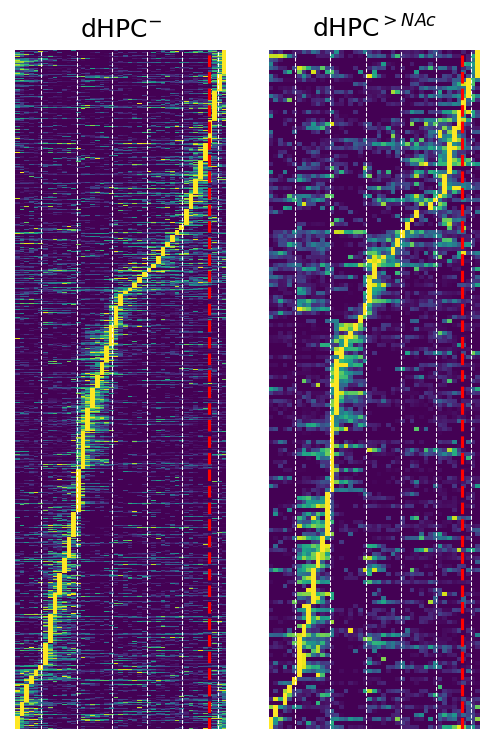

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(4,6))

BinnedHeat = hmap_green.T.reindex(hmap_green.idxmax().sort_values(ascending=False).index.tolist())
BinnedHeat = BinnedHeat.sub(BinnedHeat.min(axis=1), axis=0)
BinnedHeat = BinnedHeat.div(BinnedHeat.max(axis=1), axis=0)
sns.heatmap(BinnedHeat, cmap='viridis', ax=axs[0], cbar=None)
axs[0].axvline(41.25, linestyle='--', color='red')
[axs[0].axvline(x+3.75, ls='--', c='white', lw=0.5) for x in [1.875, 9.375, 16.875, 24.375, 31.875, 39.375]]
axs[0].axis('off');
axs[0].set_title('dHPC$^{-}$');

BinnedHeat = hmap_red.T.reindex(hmap_red.idxmax().sort_values(ascending=False).index.tolist())
BinnedHeat = BinnedHeat.sub(BinnedHeat.min(axis=1), axis=0)
BinnedHeat = BinnedHeat.div(BinnedHeat.max(axis=1), axis=0)
sns.heatmap(BinnedHeat, cmap='viridis', ax=axs[1], cbar=None)
axs[1].axvline(41.25, linestyle='--', color='red')
[axs[1].axvline(x+3.75, ls='--', c='white', lw=0.5) for x in [1.875, 9.375, 16.875, 24.375, 31.875, 39.375]]
axs[1].axis('off');
axs[1].set_title('dHPC$^{>NAc}$');

# Figure 4B

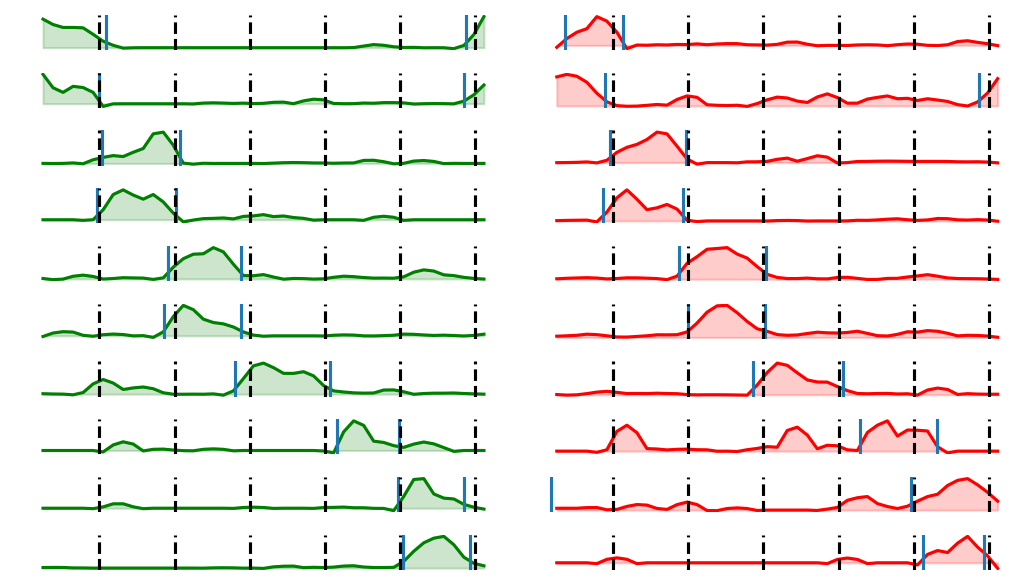

In [6]:
fig, axs = plt.subplots(10,2, figsize=(7,4), sharex=True, sharey=False)

greencells = [(166, 756), (152, 25), (152, 24), (152, 153), (152, 43), (152, 222), (152, 116), (152, 4), (152, 59), (125, 66)]  # 1, 1, 2, 2, 3, 3, 4, 5, 6, 6
redcells = [(148, 377), (139, 253), (152, 174), (152, 167), (152, 131), (125, 65), (152, 48),(139, 243), (142, 187), (103, 88)]  # 1, 1, 2, 2, 3, 3, 4, 5, 6, 6

greenplot = []
redplot = []

for i, j in enumerate(greencells):
    expID = j[0]
    cell = j[1]
    S_exp = S[expID]
    behaviour_exp = behaviour.loc[expID].reset_index(drop=True)
    behaviour_exp['PositionBin'] = pd.cut(behaviour_exp.Position, 45, labels=False)
    S_exp = S_exp.drop(['PositionBin', 'Lap'], axis=1).join(behaviour_exp[['PositionBin', 'Lap', 'Velocity_ds']], on='Frame')
    S_mov = S_exp.loc[S_exp.Velocity_ds>2].reset_index()
    S_PosLap = S_mov.groupby(['Lap', 'PositionBin']).mean()
    S_gauss = S_PosLap.rolling(window=5, win_type='gaussian', center=True).mean(std=1.5)
    S_pos_raw = S_PosLap.reset_index().groupby('PositionBin').mean().drop(['Lap', 'Velocity_ds'], axis=1)
    S_pos = S_gauss.reset_index().groupby('PositionBin').mean().drop(['Lap', 'Velocity_ds'], axis=1)

    if comps.loc[(comps.ExpID==expID)&(comps.NeuronID==cell), 'Red'].values==1:
        axs[i,0].plot(savgol_filter(S_pos_raw[cell].values, 5, 2), color='r')
    else:
        axs[i,0].plot(savgol_filter(S_pos_raw[cell].values, 5, 2), color='g')
    greenplot.append(savgol_filter(S_pos_raw[cell].values, 5, 2))
    axs[i,0].fill_between(S_pos_raw[cell].index, savgol_filter(S_pos_raw[cell].values, 5, 2), color='green', alpha=0.2)
    axs[i,0].set_ylabel(str(cell))
    axs[i,0].axvline(comps.loc[(comps.ExpID==expID)&(comps.NeuronID==cell), 'PF1_start'].values)
    axs[i,0].axvline(comps.loc[(comps.ExpID==expID)&(comps.NeuronID==cell), 'PF1_end'].values)
    for x in [0, 7.5, 15, 22.5, 30, 37.5]:
        axs[i,0].axvline(x+5.625, color='k', ls='--')
    axs[i,0].axis('off');

for i, j in enumerate(redcells):
    expID = j[0]
    cell = j[1]
    S_exp = S[expID]
    behaviour_exp = behaviour.loc[expID].reset_index(drop=True)
    behaviour_exp['PositionBin'] = pd.cut(behaviour_exp.Position, 45, labels=False)
    S_exp = S_exp.drop(['PositionBin', 'Lap'], axis=1).join(behaviour_exp[['PositionBin', 'Lap', 'Velocity_ds']], on='Frame')
    S_mov = S_exp.loc[S_exp.Velocity_ds>2].reset_index()
    S_PosLap = S_mov.groupby(['Lap', 'PositionBin']).mean()
    S_gauss = S_PosLap.rolling(window=5, win_type='gaussian', center=True).mean(std=1.5)
    S_pos_raw = S_PosLap.reset_index().groupby('PositionBin').mean().drop(['Lap', 'Velocity_ds'], axis=1)
    S_pos = S_gauss.reset_index().groupby('PositionBin').mean().drop(['Lap', 'Velocity_ds'], axis=1)

    if comps.loc[(comps.ExpID==expID)&(comps.NeuronID==cell), 'Red'].values==1:
        axs[i,1].plot(savgol_filter(S_pos_raw[cell].values, 5, 2), color='r')
    else:
        axs[i,1].plot(savgol_filter(S_pos_raw[cell].values, 5, 2), color='g')
    redplot.append(savgol_filter(S_pos_raw[cell].values, 5, 2))
    axs[i,1].fill_between(S_pos_raw[cell].index, savgol_filter(S_pos_raw[cell].values, 5, 2), color='red', alpha=0.2)
    axs[i,1].set_ylabel(str(cell))
    axs[i,1].axvline(comps.loc[(comps.ExpID==expID)&(comps.NeuronID==cell), 'PF1_start'].values)
    axs[i,1].axvline(comps.loc[(comps.ExpID==expID)&(comps.NeuronID==cell), 'PF1_end'].values)
    for x in [0, 7.5, 15, 22.5, 30, 37.5]:
        axs[i,1].axvline(x+5.625, color='k', ls='--')
    axs[i,1].axis('off');
fig.tight_layout()

# Figure 4C+D; S5J-M

In [7]:
mid_zone = [0,1,2,7,8,9,10,15,16,17,18,23,24,25,26,31,32,33,38,39,40,45]
transition_zone = [3,4,5,6,11,12,13,14,19,20,21,22,27,28,29,30,34,35,36,37,42,43,44]

In [8]:
comps.loc[~pd.isnull(comps.PF1), ['PF1_Tzone', 'PF1_start_Tzone', 'PF1_end_Tzone']] = comps.loc[~pd.isnull(comps.PF1), 
    ['PF1', 'PF1_start', 'PF1_end']].astype(int).isin(transition_zone).astype(float).values
comps.groupby('Red').mean()[['PF1_Tzone', 'PF1_start_Tzone', 'PF1_end_Tzone']]

,PF1_Tzone,PF1_start_Tzone,PF1_end_Tzone
Red,,,
False,0.509307,0.577623,0.543874
True,0.539503,0.634312,0.593679


In [9]:
all_shuffles = []
all_pfshuffles = []
for i in tqdm(range(1000)):
    np.random.seed(i)
    pfshuffledcomps = comps[['PF1', 'PF1_start', 'PF1_end']].reset_index(drop=True) + pd.DataFrame([np.random.randint(0, 44, comps.shape[0])]*3).T.values
    pfshuffledcomps[pfshuffledcomps>=45] = pfshuffledcomps[pfshuffledcomps>=45] - 45
    pfshuffledcomps[['Red', 'PlaceCell']] = comps[['Red', 'PlaceCell']].values
    pfshuffledcomps = pfshuffledcomps.dropna()
    pfshuffledcomps[['PF1_Tzone', 'PF1_start_Tzone', 'PF1_end_Tzone']] = pfshuffledcomps[['PF1', 'PF1_start', 'PF1_end']].astype(int).isin(transition_zone)
    all_shuffles.append(pfshuffledcomps.groupby('Red').mean([['PF1_Tzone', 'PF1_start_Tzone', 'PF1_end_Tzone']]))
    all_pfshuffles.append(pfshuffledcomps[['PF1', 'PF1_start', 'PF1_end']].apply(lambda x: np.histogram(x, bins=45, range=(0, 45), density=True)[0]).join(comps.Red.reset_index(drop=True)))
all_shuffles = pd.concat(all_shuffles)
all_pfshuffles = pd.concat(all_pfshuffles)

100%|██████████| 1000/1000 [01:03<00:00, 15.66it/s]


In [10]:
all_pfshuffles = all_pfshuffles.reset_index()
all_pfshuffles

,index,PF1,PF1_start,PF1_end,Red
0,0,0.022693,0.021193,0.020259,False
1,1,0.022318,0.027569,0.024761,False
2,2,0.022506,0.025131,0.023635,False
3,3,0.022506,0.023443,0.024386,False
4,4,0.023818,0.021380,0.022322,False
...,...,...,...,...,...
44995,40,0.021943,0.021193,0.021388,False
44996,41,0.021568,0.019505,0.020075,False
44997,42,0.019880,0.020068,0.023452,True
44998,43,0.022506,0.024006,0.021764,False


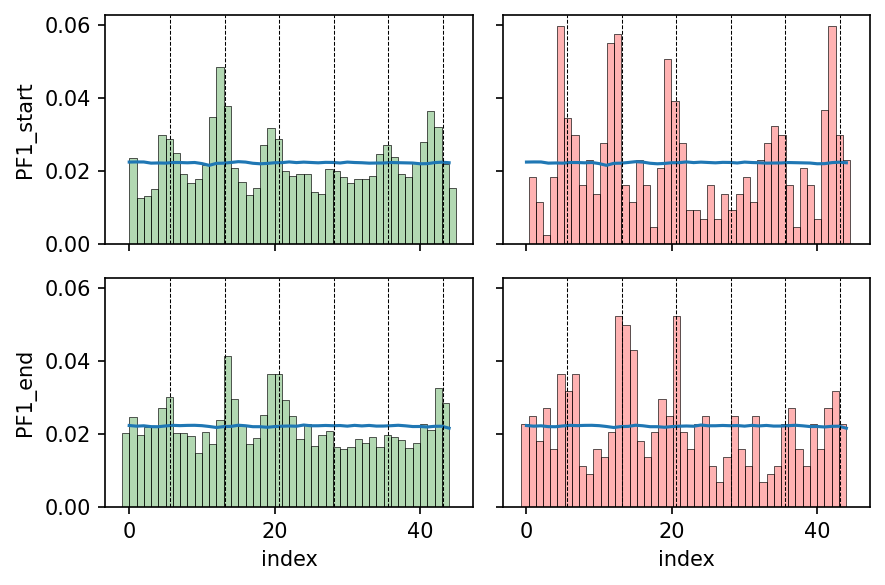

In [11]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
sns.lineplot(data=all_pfshuffles, x='index', y='PF1_start', ci=None, ax=axs[0,0], legend=None)
sns.histplot(data=comps.loc[comps.Red==0], x='PF1_start', bins=45, ax=axs[0,0], stat='density', common_norm=False, kde=False,
    kde_kws={'bw_adjust': .2}, legend=None, color='g', alpha=0.3)
for x in [0, 7.5, 15, 22.5, 30, 37.5]:
    axs[0,0].axvline(x+5.625, color='k', ls='--', lw=0.5)    

sns.lineplot(data=all_pfshuffles, x='index', y='PF1_start', ci=None, ax=axs[0,1], legend=None)
sns.histplot(data=comps.loc[comps.Red==1], x='PF1_start', bins=45, ax=axs[0,1], stat='density', common_norm=False, kde=False,
    kde_kws={'bw_adjust': .2}, legend=None, color='r', alpha=0.3)
for x in [0, 7.5, 15, 22.5, 30, 37.5]:
    axs[0,1].axvline(x+5.625, color='k', ls='--', lw=0.5)  

sns.lineplot(data=all_pfshuffles, x='index', y='PF1_end', ci=None, ax=axs[1,0], legend=None)
sns.histplot(data=comps.loc[comps.Red==0], x='PF1_end', bins=45, ax=axs[1,0], stat='density', common_norm=False, kde=False,
    kde_kws={'bw_adjust': .2}, legend=None, color='g', alpha=0.3)
for x in [0, 7.5, 15, 22.5, 30, 37.5]:
    axs[1,0].axvline(x+5.625, color='k', ls='--', lw=0.5)  

sns.lineplot(data=all_pfshuffles, x='index', y='PF1_end', ci=None, ax=axs[1,1], legend=None)
sns.histplot(data=comps.loc[comps.Red==1], x='PF1_end', bins=45, ax=axs[1,1], stat='density', common_norm=False, kde=False,
    kde_kws={'bw_adjust': .2}, legend=None, color='r', alpha=0.3)
for x in [0, 7.5, 15, 22.5, 30, 37.5]:
    axs[1,1].axvline(x+5.625, color='k', ls='--', lw=0.5)  

fig.tight_layout()

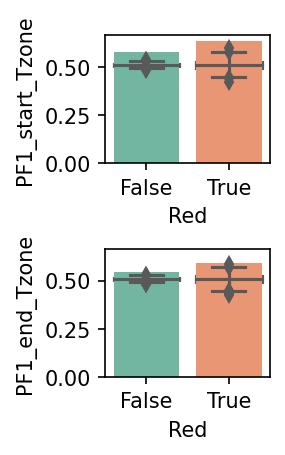

In [12]:
fig, axs = plt.subplots(2,1, figsize=(2,3), sharey=True)
sns.boxplot(data=all_shuffles.reset_index(), x='Red', y='PF1_start_Tzone', ax=axs[0], palette='Set2')
sns.barplot(data=comps, x='Red', y='PF1_start_Tzone', ax=axs[0], palette='Set2', ci=None)
sns.boxplot(data=all_shuffles.reset_index(), x='Red', y='PF1_end_Tzone', ax=axs[1], palette='Set2')
sns.barplot(data=comps, x='Red', y='PF1_end_Tzone', ax=axs[1], palette='Set2', ci=None)

fig.tight_layout()

In [13]:
# compare true proportion of place field BEGINNINGS in transition zone with 999th percentile of shuffled distribution
pd.concat([comps.groupby('Red').mean()['PF1_start_Tzone'], all_shuffles.reset_index().groupby('Red').quantile(.999)['PF1_start_Tzone']], axis=1)

,PF1_start_Tzone,PF1_start_Tzone
Red,,
False,0.577623,0.534264
True,0.634312,0.580156


In [14]:
# compare true proportion of place field ENDINGS in transition zone with 999th percentile of shuffled distribution
pd.concat([comps.groupby('Red').mean()['PF1_end_Tzone'], all_shuffles.reset_index().groupby('Red').quantile(.999)['PF1_end_Tzone']], axis=1)

,PF1_end_Tzone,PF1_end_Tzone
Red,,
False,0.543874,0.528329
True,0.593679,0.573379


In [15]:
# compare ratios between red and green cells for start
pg.chi2_independence(comps, x='PF1_start_Tzone',y='Red')

(Red                    False        True
 PF1_start_Tzone                         
 0.0              2041.973556  185.026444
 1.0              2847.026444  257.973556,
 Red               False   True
 PF1_start_Tzone               
 0.0              2064.5  162.5
 1.0              2824.5  280.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  5.136297  1.0  0.023431  0.030921  0.620353
 1        cressie-read  0.666667  5.156297  1.0  0.023162  0.030981  0.622029
 2      log-likelihood  0.000000  5.199594  1.0  0.022592  0.031111  0.625640
 3       freeman-tukey -0.500000  5.235024  1.0  0.022137  0.031217  0.628575
 4  mod-log-likelihood -1.000000  5.273059  1.0  0.021658  0.031330  0.631707
 5              neyman -2.000000  5.357220  1.0  0.020637  0.031579  0.638566)

In [16]:
# compare ratios between red and green cells for end
pg.chi2_independence(comps, x='PF1_end_Tzone',y='Red')

(Red                  False        True
 PF1_end_Tzone                         
 0.0            2209.769317  200.230683
 1.0            2679.230683  242.769317,
 Red             False   True
 PF1_end_Tzone               
 0.0            2229.5  180.5
 1.0            2659.5  262.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  3.869311  1.0  0.049177  0.026838  0.502872
 1        cressie-read  0.666667  3.877174  1.0  0.048947  0.026865  0.503669
 2      log-likelihood  0.000000  3.894596  1.0  0.048442  0.026925  0.505431
 3       freeman-tukey -0.500000  3.909167  1.0  0.048023  0.026976  0.506902
 4  mod-log-likelihood -1.000000  3.925049  1.0  0.047572  0.027031  0.508501
 5              neyman -2.000000  3.960827  1.0  0.046571  0.027153  0.512093)

In [17]:
# red/green comparisons estimation statistics
comps['RedC'] = 'Green'
comps.loc[comps.Red==1, 'RedC'] = 'Red'
comps.RedC

startzone = dabest.load(comps, idx=("Green", "Red"), x='RedC', y='PF1_start_Tzone', resamples=5000, proportional=True)
startzone.cohens_h.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Green,Red,4889,443,Cohen's h,None,0.116086,95,0.019269,0.211702,0.0152,0.018406,-2.36466,0.020521,-2.317376,0.020536,1021525.0


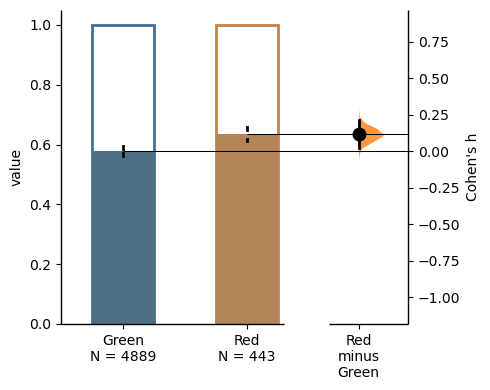

In [18]:
startzone.cohens_h.plot();

In [19]:
endzone = dabest.load(comps, idx=("Green", "Red"), x='RedC', y='PF1_end_Tzone', resamples=5000, proportional=True)
endzone.cohens_h.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Green,Red,4889,443,Cohen's h,None,0.100612,95,0.001521,0.198415,0.0422,0.041924,-2.039242,0.043715,-2.017295,0.043727,1028978.5


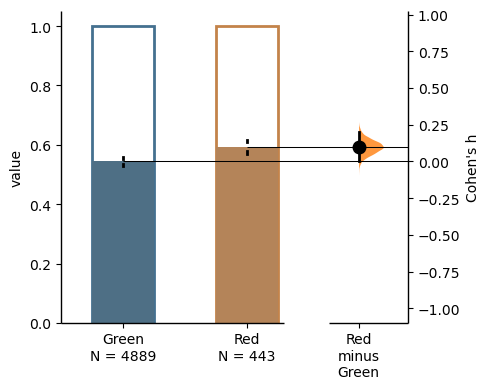

In [20]:
endzone.cohens_h.plot();

In [21]:
midzone = dabest.load(comps, idx=("Green", "Red"), x='RedC', y='PF1_Tzone', resamples=5000, proportional=True)
midzone.cohens_h.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Green,Red,4889,443,Cohen's h,None,0.060475,95,-0.03818,0.157725,0.2146,0.223228,-1.219429,0.22348,-1.217468,0.223454,1050213.0


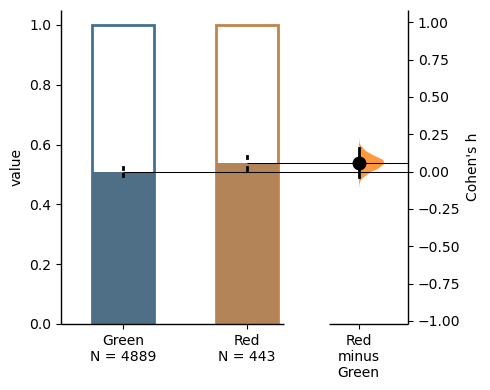

In [22]:
midzone.cohens_h.plot();

# Figure 4E

In [23]:
# posted by @kingjr at https://stackoverflow.com/a/44783738
def vonmises_kde(data, kappa, n_bins=100):
    from scipy.special import i0
    bins = np.linspace(-np.pi, np.pi, n_bins)
    x = np.linspace(-np.pi, np.pi, n_bins)
    # integrate vonmises kernels
    kde = np.exp(kappa*np.cos(x[:, None]-data[None, :])).sum(1)/(2*np.pi*i0(kappa))
    kde /= np.trapz(kde, x=bins)
    return bins, kde

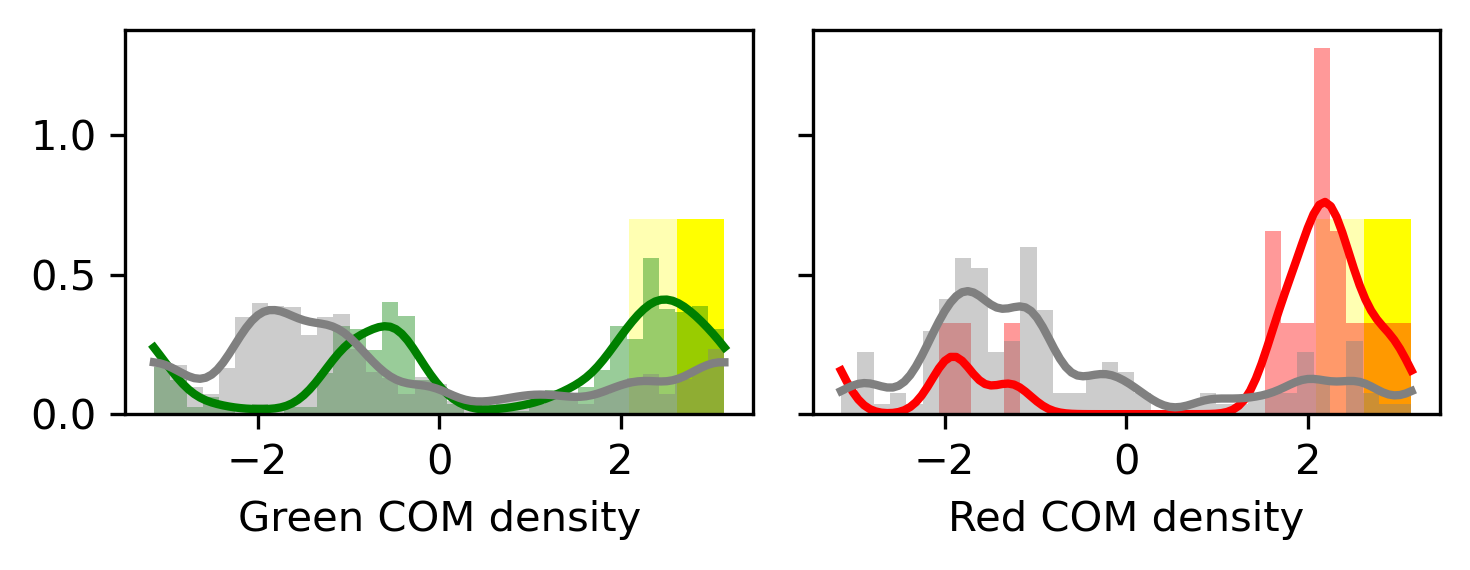

In [24]:
comps.Red = comps.Red.astype(float)
all_components = comps
if 'ExpID' not in all_components.columns:
    all_components = all_components.reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(5,2), dpi=300, sharey=True)
axs[0].add_patch(Rectangle((np.pi-(np.pi/6), 0), np.pi/6, 0.7, facecolor='yellow', alpha=1))
axs[0].add_patch(Rectangle((np.pi-2*(np.pi/6), 0), np.pi/6, 0.7, facecolor='yellow', alpha=0.3))
axs[1].add_patch(Rectangle((np.pi-(np.pi/6), 0), np.pi/6, 0.7, facecolor='yellow', alpha=1))
axs[1].add_patch(Rectangle((np.pi-2*(np.pi/6), 0), np.pi/6, 0.7, facecolor='yellow', alpha=0.3))
for success in [True, False]:
    if success:
        data = np.radians(all_components.loc[(all_components.success_exp) & (all_components.PlaceScoreShufflingPercentile>95) & (all_components.Red==0), 'ComAngle'].astype(float).values)-np.pi
        sns.distplot(data, bins=np.linspace(-np.pi, np.pi, 36), kde=False, norm_hist=True, ax=axs[0], color='g')
        x, kde = vonmises_kde(data[~pd.isnull(data)], 20)
        axs[0].plot(x, kde, c='g', lw=2)

        data = np.radians(all_components.loc[(all_components.success_exp) & (all_components.PlaceScoreShufflingPercentile>95) & (all_components.Red==1), 'ComAngle'].astype(float).values)-np.pi
        sns.distplot(data, bins=np.linspace(-np.pi, np.pi, 36), kde=False, norm_hist=True, ax=axs[1], color='r')
        x, kde = vonmises_kde(data[~pd.isnull(data)], 20)
        axs[1].plot(x, kde, c='r', lw=2)
    else:
        data = np.radians(all_components.loc[~(all_components.success_exp) & (all_components.PlaceScoreShufflingPercentile>95) & (all_components.Red==0), 'ComAngle'].astype(float).values)-np.pi
        sns.distplot(data, bins=np.linspace(-np.pi, np.pi, 36), kde=False, norm_hist=True, ax=axs[0], color='grey')
        x, kde = vonmises_kde(data[~pd.isnull(data)], 20)
        axs[0].plot(x, kde, c='grey', lw=2)

        data = np.radians(all_components.loc[~(all_components.success_exp) & (all_components.PlaceScoreShufflingPercentile>95) & (all_components.Red==1), 'ComAngle'].astype(float).values)-np.pi
        sns.distplot(data, bins=np.linspace(-np.pi, np.pi, 36), kde=False, norm_hist=True, ax=axs[1], color='grey')
        x, kde = vonmises_kde(data[~pd.isnull(data)], 20)
        axs[1].plot(x, kde, c='grey', lw=2)
    axs[0].set_xlabel('Green COM density')
    axs[1].set_xlabel('Red COM density')
fig.tight_layout()


# Figure 3F

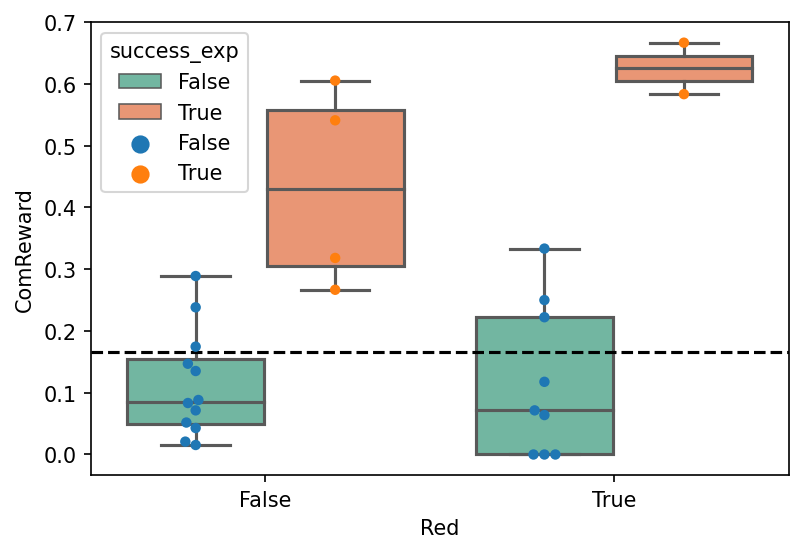

In [25]:
sns.boxplot(data=success_comreward.reset_index(), x='Red', y='ComReward', hue='success_exp', palette='Set2')
sns.swarmplot(data=success_comreward.reset_index(), x='Red', y='ComReward', hue='success_exp', dodge=True)
plt.axhline(60/360, ls='--', c='k')

In [26]:
pg.anova(data=success_comreward.reset_index(), dv='ComReward', between=['success_exp', 'Red']).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,success_exp,0.690,1.0,0.690,54.918,0.000,0.705
1,Red,0.012,1.0,0.012,0.958,0.338,0.040
2,success_exp * Red,0.037,1.0,0.037,2.969,0.098,0.114
3,Residual,0.289,23.0,0.013,NaN,NaN,NaN


In [54]:
success_comreward['ComReward'] = success_comreward['ComReward'].astype(float)
pg.pairwise_tests(data=success_comreward.reset_index(), dv='ComReward', 
                  between=['Red', 'success_exp'], padjust='bonf', within_first=True)

,Contrast,Red,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Red,-,False,True,False,False,94.5,two-sided,0.766998,NaN,NaN,-0.080847
1,success_exp,-,False,True,False,False,3.0,two-sided,0.000515,NaN,NaN,-3.181526
2,Red * success_exp,False,False,True,False,False,1.0,two-sided,0.002198,0.004396,bonf,-2.790755
3,Red * success_exp,True,False,True,False,False,0.0,two-sided,0.043183,0.086366,bonf,-3.936327


In [28]:
# success_comreward = success_comreward.reset_index()
success_df = pd.DataFrame({
    'green_nosuccess': success_comreward.loc[(success_comreward.Red==0)&(success_comreward.success_exp==0), 'ComReward'],
    'green_success': success_comreward.loc[(success_comreward.Red==0)&(success_comreward.success_exp==1), 'ComReward'],
    'red_nosuccess': success_comreward.loc[(success_comreward.Red==1)&(success_comreward.success_exp==0), 'ComReward'],
    'red_success': success_comreward.loc[(success_comreward.Red==1)&(success_comreward.success_exp==1), 'ComReward'],
})
success_df = success_df.astype(float)
success_df

green_success = dabest.load(success_df, idx=(("green_nosuccess", "green_success"),
                                             ("red_nosuccess", "red_success")))
green_success.median_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_kruskal,statistic_kruskal
0,green_nosuccess,green_success,12,4,median difference,None,0.343798,95,0.151387,0.521399,0.0,0.005285,7.779412
1,red_nosuccess,red_success,9,2,median difference,None,0.553571,95,0.361111,0.666667,0.0,0.032284,4.583333


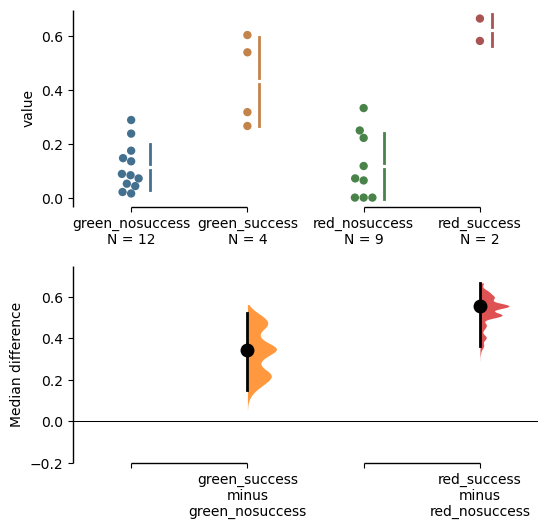

In [29]:
green_success.median_diff.plot(contrast_ylim=(-0.2, 0.75));

In [30]:
green_success_T = dabest.load(success_df, idx=(("green_nosuccess", "red_nosuccess"),
                                             ("green_success", "red_success")))
green_success_T.median_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_kruskal,statistic_kruskal
0,green_nosuccess,red_nosuccess,12,9,median difference,None,-0.014356,95,-0.146939,0.142390,0.7044,0.695425,0.153275
1,green_success,red_success,4,2,median difference,None,0.195417,95,0.010210,0.358333,0.1358,0.164915,1.928571


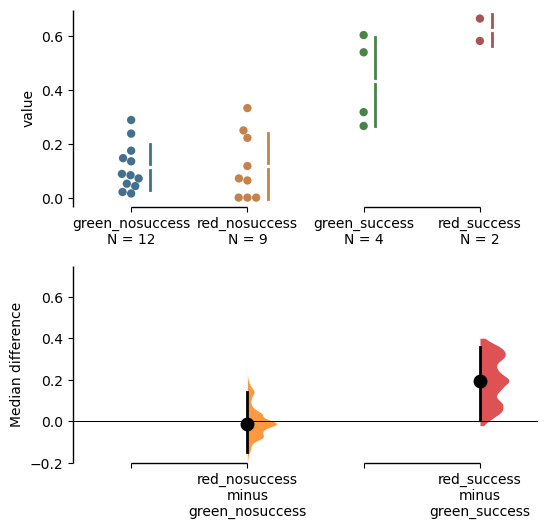

In [31]:
green_success_T.median_diff.plot(contrast_ylim=(-0.2, 0.75));

In [32]:
green_success = dabest.load(success_df, idx=(("green_nosuccess", "red_nosuccess"),
                                             ("green_success", "red_success")))
green_success.median_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_kruskal,statistic_kruskal
0,green_nosuccess,red_nosuccess,12,9,median difference,None,-0.014356,95,-0.146939,0.142390,0.7044,0.695425,0.153275
1,green_success,red_success,4,2,median difference,None,0.195417,95,0.010210,0.358333,0.1358,0.164915,1.928571


# Figure 4G

In [33]:
# FUNCTIONS

def ds_data(S_, binarise, beh, ds_sec, velothresh=2, bins=45):
    # binarise events (discard amplitude information)
    if binarise:
        S_ = (S_>0).astype(float)
    else:
        S_ = pd.DataFrame(S_)
        S_[S_>0] = S.apply(lambda x: pd.qcut(x[x>0], 10, labels=False))  # quantiles
        # S[S>0] = S.apply(lambda x: (x/x.std()+1).astype(int))  # z-scored
        S_ = S_.values

    # Velocity below 2cm/s is NANed
    S_[(beh.Velocity_ds<velothresh),:] = np.nan
    beh[(beh.Velocity_ds<velothresh)] = np.nan

    # downsampling
    beh['Time_ds'] = round(beh.Time_s / ds_sec)
    S_ds = pd.DataFrame(S_).join(beh.Time_ds).groupby('Time_ds').sum().values
    beh_ds = beh.groupby('Time_ds').median().reset_index()
    beh_ds.Lap = round(beh_ds.Lap)
    beh_ds['Pump'] = beh.groupby('Time_ds').max().reset_index()['Pump']

    # kicking out NANs at Position
    S_ds = S_ds[beh_ds.loc[~beh_ds.Position.isnull()].index, :]
    beh_ds = beh_ds.loc[~beh_ds.Position.isnull()].reset_index(drop=True)

    # bin position
    beh_ds['PosBin'] = pd.cut(beh_ds.Position, bins, labels=False)
    beh_ds['VeloBin'] = pd.cut(beh_ds.Velocity_ds, bins, labels=False)

    # discretise reward zone
    beh_ds['RewZone'] = (beh_ds.Position>330).astype(int)
    beh_ds['AntZone'] = ((beh_ds.Position>300)&(beh_ds.Position<330)).astype(int)
    beh_ds['RewAntZone'] = (beh_ds.Position>300).astype(int)

    # define lap success
    lapsuccess = beh_ds.groupby('Lap').max()['Pump'].rename('LapSuccess')
    beh_ds = beh_ds.join(lapsuccess, on='Lap')
    
    return S_ds, beh_ds


def train_test(S_ds, beh_ds, comps_, red=0, eventthresh=10, train_odd_laps=1, random_state=1):    
    # set 'red_events' to NaN for neurons with less than X event bins
    comps_['Red_events'] = comps_.Red
    comps_.loc[(np.sum(S_ds>0, axis=0)<eventthresh), 'Red_events'] = np.nan
    
    # pick only red/green cells with more than X events
    if red==1:
        if comps_.Red_events.sum() > len(comps_.loc[~comps_.Red]):
            S_ds = S_ds[:, comps_.loc[(comps_.Red_events==1)].sample(len(comps_.loc[~comps_.Red]), random_state=random_state).index]
        else:
            S_ds = S_ds[:, (comps_.Red_events==1)]  # red
    elif red==0:  # sample-size-matched green neurons
        if comps_.Red_events.sum() > len(comps_.loc[~comps_.Red]):
            S_ds = S_ds[:, (comps_.Red==0)]  # green
        else:
            S_ds = S_ds[:, comps_.loc[(comps_.Red==0)].sample(comps_.Red_events.sum(), random_state=random_state).index]  # green same randomised sample number
    elif red==-1:  # non-sample-size-matched green neurons
        S_ds = S_ds[:, (comps_.Red==0)]
    else:
        S_ds = S_ds[:, (comps_.Red_events<2)]  # all cells with more than X events
        
    # split into train/test 50/50 by laps, (discard first and last lap)
    if train_odd_laps:
        trainidx = np.where(~(beh_ds.Lap%2).astype(bool))[0]# & ~(pd.Series(beh_ds.Lap).isin([beh_ds.loc[0, 'Lap'], beh_ds.Lap.iloc[-1]])).values)[0]
        testidx = np.where((beh_ds.Lap%2).astype(bool))[0]# & ~(pd.Series(beh_ds.Lap).isin([beh_ds.loc[0, 'Lap'], beh_ds.Lap.iloc[-1]])).values)[0]
    else:
        trainidx = np.where((beh_ds.Lap%2).astype(bool))[0]# & ~(pd.Series(beh_ds.Lap).isin([beh_ds.loc[0, 'Lap'], beh_ds.Lap.iloc[-1]])).values)[0]
        testidx = np.where(~(beh_ds.Lap%2).astype(bool))[0]# & ~(pd.Series(beh_ds.Lap).isin([beh_ds.loc[0, 'Lap'], beh_ds.Lap.iloc[-1]])).values)[0]
    
    S_train = S_ds[trainidx, :]
    beh_train = beh_ds.loc[trainidx].reset_index()

    S_test = S_ds[testidx, :]
    beh_test = beh_ds.loc[testidx].reset_index()
    
    return S_train, beh_train, S_test, beh_test

In [34]:
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)

predictions_all = pd.DataFrame()

expids = [103, 125, 126, 137, 139, 142, 143, 144, 148, 152]  # exps with more than 10 red neurons
for expid in expids:
    S_exp = S[expid].drop(['PositionBin', 'Lap'], axis=1).dropna().values
    beh = behaviour.loc[expid, ['Position', 'Lap', 'Velocity_ds', 'Time_s', 'Pump']]
    comps_exp = comps.loc[comps.ExpID==expid].reset_index(drop=True)
    comps_exp['Red'] = comps_exp['Red'].astype(bool)
    n_red = comps_exp.Red.sum()
    n = comps_exp.count()[0]
    ds_sec = 1
    bins = 45

    # downsample:
    S_ds, beh_ds = ds_data(S_exp, True, beh, ds_sec, velothresh=2, bins=bins)

    for r in [0, 1, 'all']:  # green then red neurons
        n_shuffle = 100 if r==0 else 1  # 100x shuffling of green neurons
        for s in tqdm(range(n_shuffle)):
            for k in [0, 1]:  # two-fold cross-validation
                clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5, random_state = 42)

                # split data set:
                S_train, beh_train, S_test, beh_test = train_test(S_ds, beh_ds, comps_exp, red=r, eventthresh=10, train_odd_laps=k, random_state=s)
                clf.fit(S_train, beh_train['AntZone'])  # AntZone

                # predict:
                predictions = pd.Series()
                predictions['r2'] = clf.score(S_test, beh_test['AntZone'])  # AntZone
                predictions['k'] = k
                predictions['r'] = r
                predictions['s'] = s
                predictions['expid'] = str(expid)
                predictions['n'] = n_red if type(r)==int else n
                predictions_all = pd.concat([predictions_all, predictions], axis=1)

predictions_all = predictions_all.T

100%|██████████| 1/1 [00:00<00:00, 37.06it/s]


In [35]:
predictions_all

,r2,k,r,s,expid,n
0,0.783972,0.0,0.0,0.0,103,37
0,0.694779,1.0,0.0,0.0,103,37
0,0.783972,0.0,0.0,1.0,103,37
0,0.702811,1.0,0.0,1.0,103,37
0,0.780488,0.0,0.0,2.0,103,37
...,...,...,...,...,...,...
0,0.898089,1.0,0.0,99.0,152,79
0,0.878981,0.0,1.0,0.0,152,79
0,0.89172,1.0,1.0,0.0,152,79
0,0.878981,0.0,all,0,152,235


In [36]:
predictions_exps = predictions_all.groupby(['expid', 'r']).mean().reset_index()
predictions_exps

,expid,r,r2,k,s,n
0,103,0.0,0.731077,0.5,49.5,37.0
1,103,1.0,0.781013,0.5,0.0,37.0
2,103,all,0.744574,0.5,0.0,237.0
3,125,0.0,0.843517,0.5,49.5,15.0
4,125,1.0,0.838041,0.5,0.0,15.0
5,125,all,0.867749,0.5,0.0,68.0
6,126,0.0,0.846373,0.5,49.5,13.0
7,126,1.0,0.857154,0.5,0.0,13.0
8,126,all,0.851067,0.5,0.0,68.0
9,137,0.0,0.802881,0.5,49.5,18.0


In [37]:
predictions_exps['r'] = predictions_exps['r'].astype(str)
pg.wilcoxon(predictions_exps.loc[predictions_exps.r=='0.0', 'r2'], predictions_exps.loc[predictions_exps.r=='1.0', 'r2'])


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,5.0,two-sided,0.019531,-0.818182,0.39


<AxesSubplot:xlabel='r', ylabel='r2'>

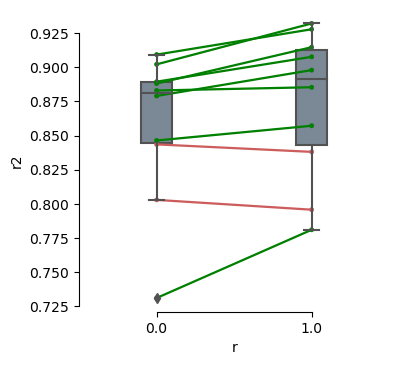

In [38]:
pg.plot_paired(data=predictions_exps.loc[predictions_exps.r!='all'], dv='r2', within='r', subject='expid')

In [39]:
predictions_exps['redgreen'] = np.nan
predictions_exps.loc[predictions_exps.r=='0.0', 'redgreen'] = 'green'
predictions_exps.loc[predictions_exps.r=='1.0', 'redgreen'] = 'red'

In [40]:
pg.normality(predictions_exps.r2)

,W,pval,normal
r2,0.946203,0.133663,True


In [41]:
predictions_stats = dabest.load(predictions_exps.loc[predictions_exps.r!='all'], idx=('green', 'red'), x="redgreen", y='r2', paired="sequential", id_col="expid")
predictions_stats.mean_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,green,red,10,10,mean difference,sequential,0.016267,95,0.006999,0.02685,0.0176,0.019531,5.0,0.015534,-2.976661


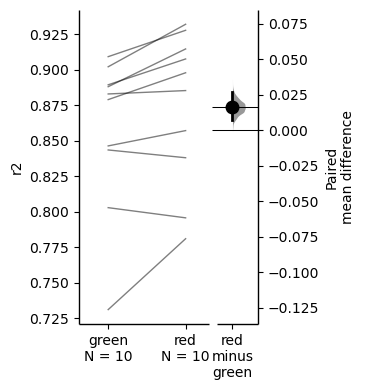

In [42]:
predictions_stats.mean_diff.plot();

# Figure S5H

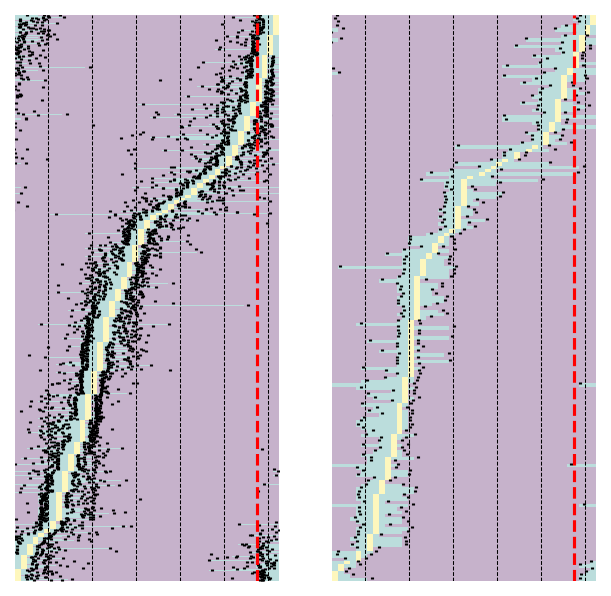

In [43]:
comps.Red = comps.Red.astype(bool)

fig, axs = plt.subplots(1,2, figsize=(5,5))

boundaryheat = pd.DataFrame(columns=np.arange(45), index=np.arange(len(comps.loc[(~comps.Red)&(comps.PlaceCell)])))
boundaryheat[:] = 0
for idx, row in comps.loc[(~comps.Red)&(comps.PlaceCell), ['PF1_start', 'PF1', 'PF1_end']].sort_values('PF1', ascending=False).reset_index(drop=True).iterrows():
    if not row.isnull()['PF1']:
        if row['PF1_end'] < row['PF1_start']:
            boundaryheat.iloc[idx, range(int(row['PF1_start']),45)] = 0.5
            boundaryheat.iloc[idx, range(0, int(row['PF1_end']))] = 0.5
        else:
            boundaryheat.iloc[idx, range(int(row['PF1_start']), int(row['PF1_end']))] = 0.5
        boundaryheat.iloc[idx, int(row['PF1'])] = 1
sns.heatmap(boundaryheat.astype(float), cmap='viridis', ax=axs[0], cbar=None, alpha=0.3)
axs[0].axis('off');

boundaryheat = pd.DataFrame(columns=np.arange(45), index=np.arange(len(comps.loc[(comps.Red)&(comps.PlaceCell)])))
boundaryheat[:] = 0
for idx, row in comps.loc[(comps.Red)&(comps.PlaceCell), ['PF1_start', 'PF1', 'PF1_end']].sort_values('PF1', ascending=False).reset_index(drop=True).iterrows():
    if not row.isnull()['PF1']:
        if row['PF1_end'] < row['PF1_start']:
            boundaryheat.iloc[idx, range(int(row['PF1_start']),45)] = 0.5
            boundaryheat.iloc[idx, range(0, int(row['PF1_end']))] = 0.5
        else:
            boundaryheat.iloc[idx, range(int(row['PF1_start']), int(row['PF1_end']))] = 0.5
        boundaryheat.iloc[idx, int(row['PF1'])] = 1
sns.heatmap(boundaryheat.astype(float), cmap='viridis', ax=axs[1], cbar=None, alpha=0.3)
axs[1].axis('off');

for idx, row in comps.loc[(~comps.Red)&(comps.PlaceCell), ['PF1_start', 'PF1', 'PF1_end']].sort_values('PF1', ascending=False).reset_index(drop=True).iterrows():
    if not row.isnull()['PF1']:
        axs[0].scatter(x=row['PF1_start'], y=idx, marker='|', c='k', s=1)
        axs[0].scatter(x=row['PF1_end'], y=idx, marker='|', c='k', s=1)

for idx, row in comps.loc[(comps.Red)&(comps.PlaceCell), ['PF1_start', 'PF1', 'PF1_end']].sort_values('PF1', ascending=False).reset_index(drop=True).iterrows():
    if not row.isnull()['PF1']:
        axs[1].scatter(x=row['PF1_start'], y=idx, marker='|', c='k', s=1)
        axs[1].scatter(x=row['PF1_end'], y=idx, marker='|', c='k', s=1)

axs[0].axvline(41.25, linestyle='--', color='red')
for x in [0, 7.5, 15, 22.5, 30, 37.5]:
    axs[0].axvline(x+5.625, color='k', ls='--', lw=0.5)  

axs[1].axvline(41.25, linestyle='--', color='red')
for x in [0, 7.5, 15, 22.5, 30, 37.5]:
    axs[1].axvline(x+5.625, color='k', ls='--', lw=0.5)  

# Figure S5I

In [44]:
PFwidth_quartiles = comps.loc[comps.PlaceCell, ['PF1_width', 'Red']].groupby('Red').quantile([0.25, 0.5, 0.75])
PFwidth_quartiles

PF1_width
Red                  
False 0.25   4.456037
      0.50   6.462255
      0.75   8.624297
True  0.25   4.562129
      0.50   7.362507
      0.75   8.620265

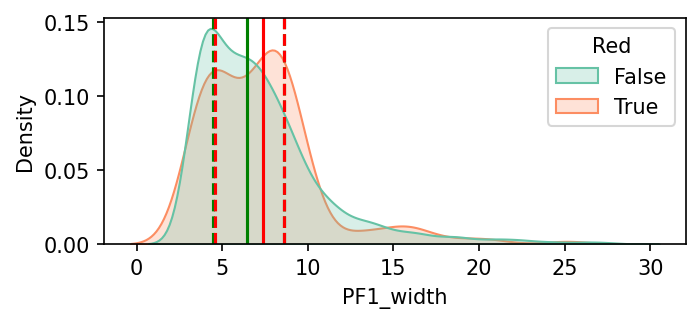

In [45]:
fig, axs = plt.subplots(1,1, figsize=(5,2))
sns.kdeplot(data=comps.loc[comps.PlaceCell], x='PF1_width', fill='Red', hue='Red', common_norm=False, palette='Set2',ax=axs)
axs.axvline(PFwidth_quartiles.values[0], ls='--', c='g')
axs.axvline(PFwidth_quartiles.values[1], c='g')
axs.axvline(PFwidth_quartiles.values[2], ls='--', c='g')
axs.axvline(PFwidth_quartiles.values[3], ls='--', c='r')
axs.axvline(PFwidth_quartiles.values[4], c='r')
axs.axvline(PFwidth_quartiles.values[5], ls='--', c='r')

In [46]:
from scipy.stats import ks_2samp
ks_2samp(comps.loc[(comps.Red)&(comps.PlaceCell), 'PF1_width'], comps.loc[(~comps.Red)&(comps.PlaceCell), 'PF1_width'])

KstestResult(statistic=0.12092189423965807, pvalue=0.020934736629834805)

# Figure S5J

<AxesSubplot:xlabel='Red', ylabel='PF1_Tzone'>

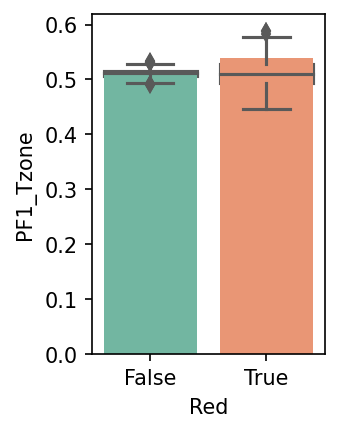

In [47]:
fig, axs = plt.subplots(1,1, figsize=(2,3), sharey=True)
sns.boxplot(data=all_shuffles.reset_index(), x='Red', y='PF1_Tzone', ax=axs, palette='Set2')
sns.barplot(data=comps, x='Red', y='PF1_Tzone', ax=axs, palette='Set2', ci=None)

In [48]:
# compare true proportion of place field CENTERS in transition zone with 95th and 5th percentile of shuffled distribution
pd.concat([comps.groupby('Red').mean()['PF1_Tzone'], all_shuffles.reset_index().groupby('Red').quantile(.95)['PF1_Tzone'], all_shuffles.reset_index().groupby('Red').quantile(.05)['PF1_Tzone']], axis=1)

,PF1_Tzone,PF1_Tzone,PF1_Tzone
Red,,,
False,0.509307,0.522806,0.499478
True,0.539503,0.550790,0.474041


# Figure S5N+O

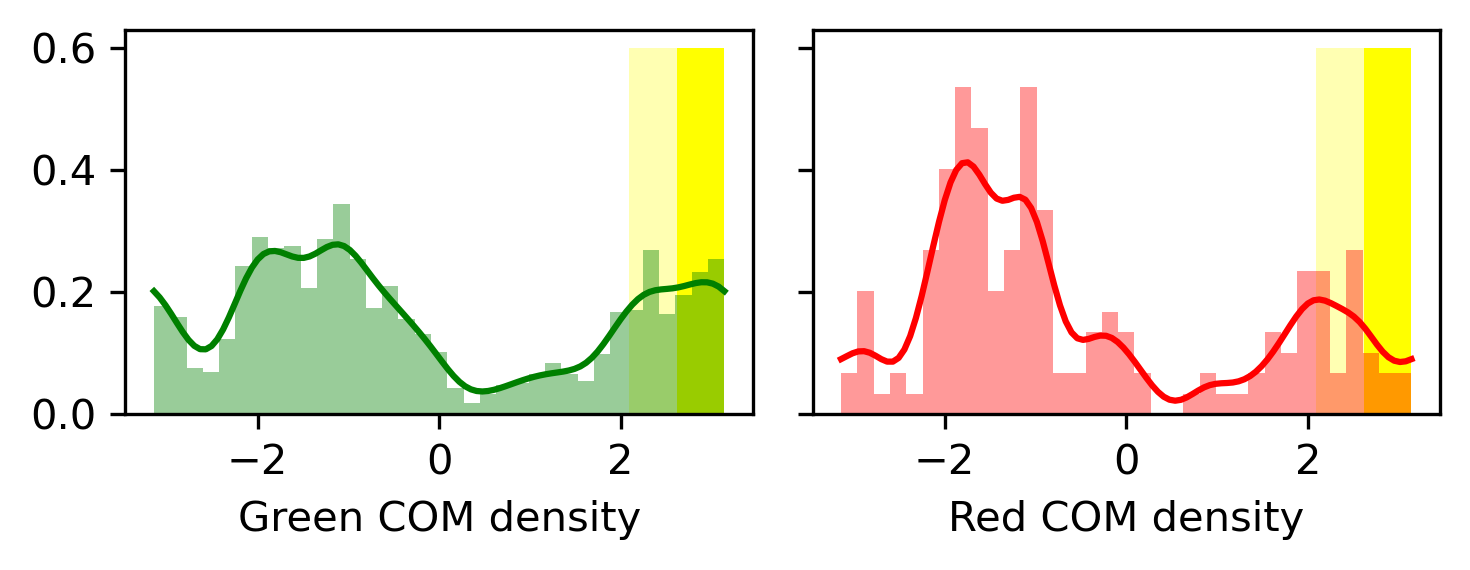

In [49]:
if 'ExpID' not in all_components.columns:
    all_components = all_components.reset_index()
fig, axs = plt.subplots(ncols=2, figsize=(5, 2), dpi=300, sharey=True)
axs[0].add_patch(Rectangle((np.pi-(np.pi/6), 0), np.pi/6, 0.6, facecolor='yellow', alpha=1))
axs[0].add_patch(Rectangle((np.pi-2*(np.pi/6), 0), np.pi/6, 0.6, facecolor='yellow', alpha=0.3))
axs[1].add_patch(Rectangle((np.pi-(np.pi/6), 0), np.pi/6, 0.6, facecolor='yellow', alpha=1))
axs[1].add_patch(Rectangle((np.pi-2*(np.pi/6), 0), np.pi/6, 0.6, facecolor='yellow', alpha=0.3))

data = np.radians(all_components.loc[(all_components.PlaceScoreShufflingPercentile>95) & (all_components.Red==0), 'ComAngle'].astype(float).values)-np.pi
sns.distplot(data, bins=np.linspace(-np.pi, np.pi, 36), kde=False, norm_hist=True, ax=axs[0], color='green')
x, kde = vonmises_kde(data[~pd.isnull(data)], 20)
axs[0].plot(x, kde, c='g')

data = np.radians(all_components.loc[(all_components.PlaceScoreShufflingPercentile>95) & (all_components.Red==1), 'ComAngle'].astype(float).values)-np.pi
sns.distplot(data, bins=np.linspace(-np.pi, np.pi, 36), kde=False, norm_hist=True, ax=axs[1], color='red')
x, kde = vonmises_kde(data[~pd.isnull(data)], 20)
axs[1].plot(x, kde, c='r')

axs[0].set_xlabel('Green COM density')
axs[1].set_xlabel('Red COM density')

fig.tight_layout()

# Figure S5Q

In [50]:
comps = comps.set_index('ExpID')
lap_mean = behaviour.groupby(['ExpID', 'Lap']).mean().reset_index().set_index('ExpID')
exp_data = pd.DataFrame((lap_mean.Pump>0).reset_index().groupby('ExpID').mean())
exp_data['COM_reward'] = (comps.loc[comps.PlaceCell, 'ComAngle']>300).groupby('ExpID').mean()
exp_data['COM_reward_g'] = (comps.loc[(~comps.Red)&(comps.PlaceCell), 'ComAngle']>300).groupby('ExpID').mean()
exp_data['COM_reward_r'] = (comps.loc[(comps.Red)&(comps.PlaceCell), 'ComAngle']>300).groupby('ExpID').mean()
exp_data['count_g'] = (comps.loc[(~comps.Red)&(comps.PlaceCell), 'ComAngle']).groupby('ExpID').count()
exp_data['count_r'] = (comps.loc[(comps.Red)&(comps.PlaceCell), 'ComAngle']).groupby('ExpID').count()
exp_data

,Pump,COM_reward,COM_reward_g,COM_reward_r,count_g,count_r
ExpID,,,,,,
100,0.333333,NaN,NaN,NaN,NaN,NaN
103,0.916667,0.547945,0.540984,0.583333,58.0,12.0
117,0.666667,0.000000,0.000000,NaN,1.0,NaN
125,0.000000,0.280702,0.288889,0.250000,45.0,12.0
126,0.000000,0.116279,0.088235,0.222222,34.0,9.0
127,0.984615,0.262295,0.266667,0.000000,60.0,1.0
136,0.783784,0.236667,0.238255,0.000000,297.0,2.0
137,0.837209,0.607595,0.605263,0.666667,75.0,3.0
139,0.900000,0.113924,0.135135,0.063830,109.0,47.0


          n         r          CI95%     p-val   BF10     power
pearson  11  0.449587  [-0.21, 0.83]  0.165332  0.877  0.296098
          n         r          CI95%     p-val   BF10     power
pearson  11  0.433864  [-0.22, 0.82]  0.182457  0.821  0.276633


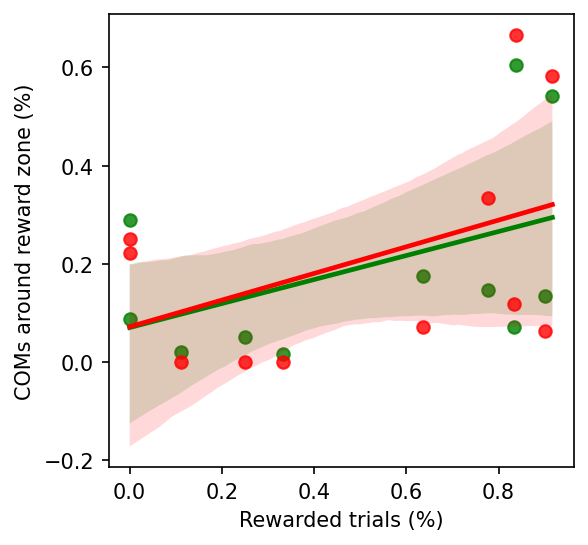

In [51]:
fig, ax = plt.subplots(figsize=(4, 4), sharex=True, sharey=True)
sns.regplot(data=exp_data.loc[(exp_data.count_r>2)], x='Pump', y='COM_reward_g', ax=ax, color='g')
sns.regplot(data=exp_data.loc[(exp_data.count_r>2)], x='Pump', y='COM_reward_r', ax=ax, color='r')
ax.set_xlabel('Rewarded trials (%)');
ax.set_ylabel('COMs around reward zone (%)');
print(pg.corr(x=exp_data.Pump.loc[exp_data.count_r>2], y=exp_data.COM_reward_g.loc[exp_data.count_r>2]))
print(pg.corr(x=exp_data.Pump.loc[exp_data.count_r>2], y=exp_data.COM_reward_r.loc[exp_data.count_r>2]))